In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import time 
import csv
import matplotlib.pyplot as plt

In [378]:
data = pd.read_csv("../data/default of credit card clients.csv", header = 1)

In [379]:
pd.set_option('display.max_columns', 1000)
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [380]:
data.rename(columns={"PAY_0" : "PAY_1"}, inplace = True)
data.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

In [381]:
def is_shifted(list_1,list_2,length):
    for i in range(1,length):
        if list_1[i-1]!=list_2[i]:
            return False
    return True

In [382]:

find_shifts = False
if find_shifts:
    age_dict = {i : [] for i in range(100)}
    for index, row in data.sort_values(by=['AGE']).iterrows():
        age_dict[row["AGE"]].append(index)
    
    problem_pairs = []
    start_time = time.time()
    for age in range(100):
        for  index in age_dict[age]:
            row = data.iloc[index]
            current_row_1 = list(row[["PAY_{}".format(i) for i in range(1,7)]])
            current_row_2 = list(row[["BILL_AMT{}".format(i) for i in range(1,7)]])
            current_row_3 = list(row[["PAY_AMT{}".format(i) for i in range(1,7)]])
            demo_row = list(row[[ "LIMIT_BAL", "SEX", "EDUCATION", "MARRIAGE", "AGE"]])
            length = 6
            for index_1 in age_dict[age]:
                row_1 = data.iloc[index_1]
                demo_row_1 = list(row_1[[ "LIMIT_BAL", "SEX", "EDUCATION", "MARRIAGE", "AGE"]])
                if index_1 != index and demo_row == demo_row_1:
                    comp_row_1 = list(row_1[["PAY_{}".format(i) for i in range(1,7)]])
                    comp_row_2 = list(row_1[["BILL_AMT{}".format(i) for i in range(1,7)]])
                    comp_row_3 = list(row_1[["PAY_AMT{}".format(i) for i in range(1,7)]])
                    if is_shifted(current_row_1, comp_row_1, 6) and is_shifted(current_row_2, comp_row_2, 6) and is_shifted(current_row_3, comp_row_3, 6):
                        problem_pairs.append((index,index_1))
        print("finished checking: ", age)
    finish_time = time.time()
    print("checking pairs completed")
    print("computation time (in sec): ", finish_time-start_time)
    print("there are {} problem pairs".format(len(problem_pairs)))

    with open("../preprocessing/shifted_pairs.csv", "w") as file:
        writer = csv.writer(file)
        for pair in problem_pairs:
            writer.writerow(list(pair))
else:
    with open("../preprocessing/shifted_pairs.csv", newline='') as file:
        reader = csv.reader(file)
        problem_pairs = list(reader)
    for index, pair in enumerate(problem_pairs):
        problem_pairs[index] = [int(pair[0]),int(pair[1])]

there are 1152 problem pairs


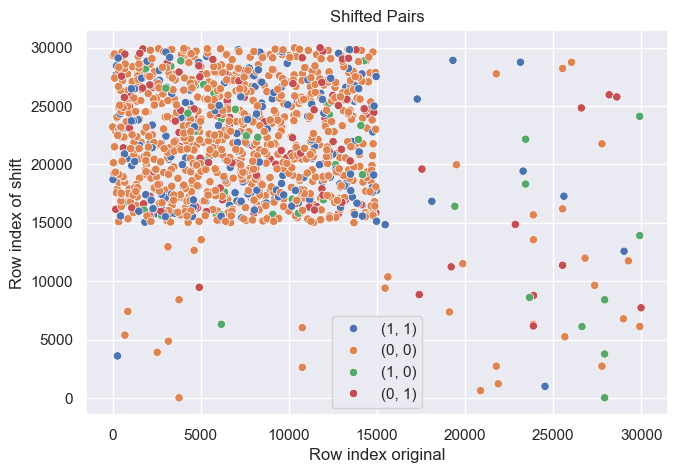

In [383]:
print("there are {} problem pairs".format(len(problem_pairs)))
x_pair = [pair[0] for pair in problem_pairs]
y_pair = [pair[1] for pair in problem_pairs]
default = [(data.iloc[pair[0]]["default payment next month"],data.iloc[pair[1]]["default payment next month"]) for pair in problem_pairs]

sns.set(rc={"figure.figsize":( 5*1.5,5)})
fig = sns.scatterplot(x = x_pair, y=y_pair, hue = default)
fig.set(xlabel = 'Row index original',
       ylabel = 'Row index of shift',
       title = 'Shifted Pairs')
plt.savefig("../images/shifted_pairs.jpg")

<Axes: xlabel='ID', ylabel='AGE'>

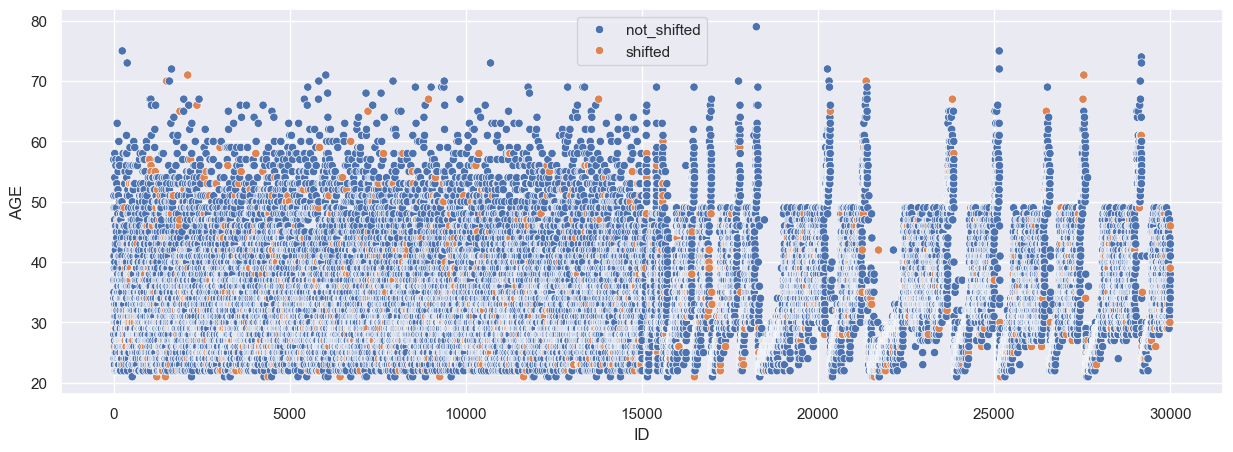

In [384]:
shifted = []
for i in range(30000):  
    if i in x_pair or i in y_pair:
        shifted.append("shifted")
    else:
        shifted.append("not_shifted")

sns.set(rc={"figure.figsize":( 15,5)})
sns.scatterplot(data=data, x= "ID", y="AGE", hue = shifted)

In [385]:
# remove shifted pairs

data.drop(y_pair,axis = 0, inplace = True)

<Axes: >

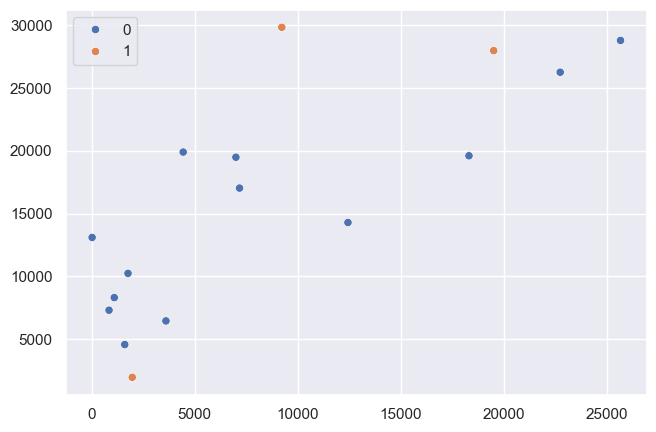

In [386]:
df = data.drop("ID", axis = 1)
duplicateRows = df[df.duplicated(keep = False)]

x_duplicate = []
y_duplicate = []
for index_1,row_1 in duplicateRows.iterrows():
    for index_2,row_2 in duplicateRows.iterrows():
        if index_1<index_2 and list(row_1)==list(row_2):
            x_duplicate.append(index_1)
            y_duplicate.append(index_2)

default = [data.iloc[index]["default payment next month"] for index in x_duplicate]

sns.set(rc={"figure.figsize":( 5*1.5,5)})
sns.scatterplot(x = x_duplicate, y=y_duplicate, hue = default)



In [387]:
# remove duplicates pairs

data.drop(y_duplicate,axis = 0, inplace = True)

In [388]:
# here is some code trying to pick out exactly the rows from the kaggle comment
df = data[data["AGE"] == 35]
df = df[df["LIMIT_BAL"] == 150000]
df = df[df["SEX"] == 1]
df = df[df["EDUCATION"]== 1]
df[df["MARRIAGE"] == 1]

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
7132,7133,150000,1,1,1,35,0,0,0,0,0,0,160292,153981,129725,103050,54447,46943,6100,5100,4200,1900,1600,1500,1
15711,15712,150000,1,1,1,35,-2,-2,-2,-2,-2,-2,5819,805,-48,8029,2188,9157,809,0,8077,2199,9202,2112,0
27127,27128,150000,1,1,1,35,-1,-1,-1,-1,-1,-1,18786,6879,16643,4869,9157,9624,6879,16701,4883,9199,9652,443,0


# Information about the data

<Axes: xlabel='default payment next month', ylabel='count'>

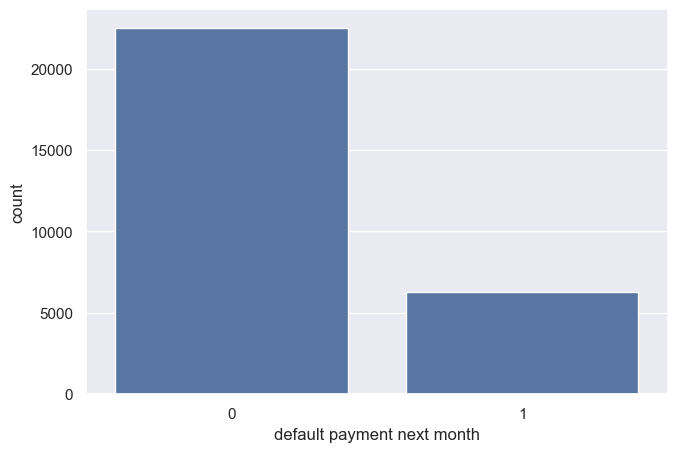

In [389]:
sns.barplot(data= data["default payment next month"].value_counts())

In [390]:
data["default payment next month"].value_counts(normalize=True)

default payment next month
0    0.781442
1    0.218558
Name: proportion, dtype: float64

<Axes: xlabel='SEX', ylabel='count'>

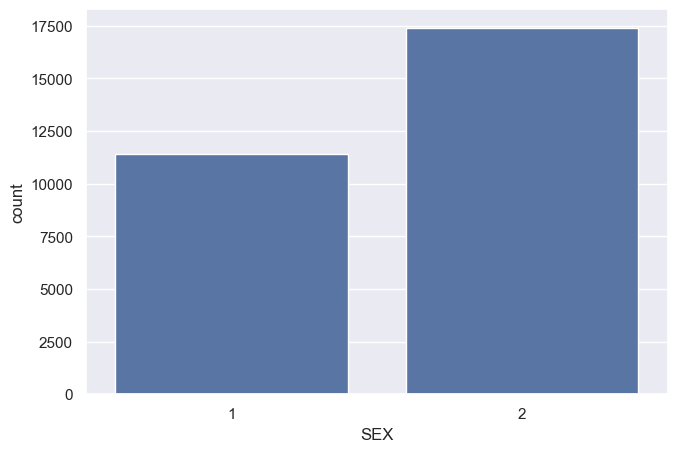

In [391]:
sns.barplot(data= data["SEX"].value_counts())

<Axes: xlabel='EDUCATION', ylabel='count'>

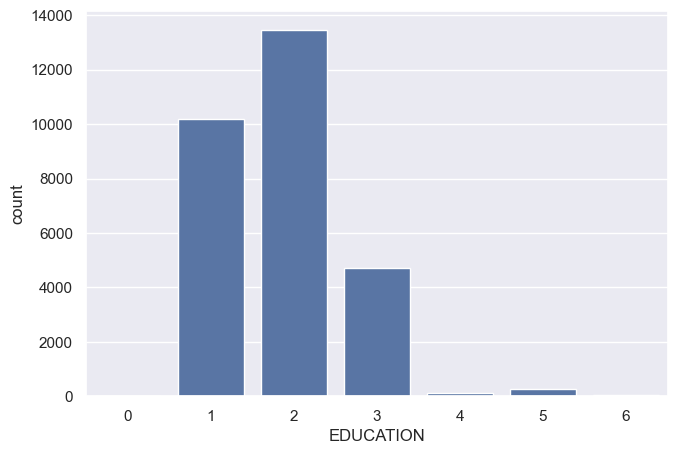

In [392]:
sns.barplot(data= data["EDUCATION"].value_counts())

The documentation for the education data only defines what the values 1 through 4 are coded as. Additionally, there are not a lot of rows for value 4, so it may be prudent to remove these data points from the data set. 

MARRIAGE
2    15346
1    13126
3      314
0       53
Name: count, dtype: int64

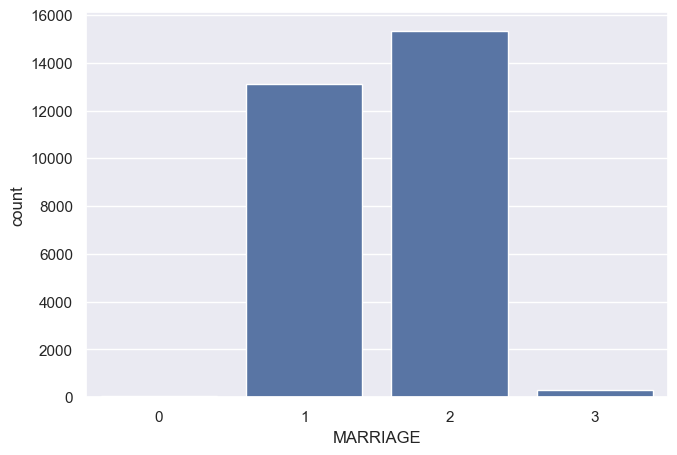

In [393]:
sns.barplot(data= data["MARRIAGE"].value_counts())
data["MARRIAGE"].value_counts()

## Checking Entries 
Here we check some of the data entries to make sure they make sense. For example, the ages of credit card clients should be between 18 and 100.

In [394]:
print("all ages are less than 100: ",(data["AGE"]<100).all())
print("all ages are greater than 17: ", (data["AGE"]>17).all())

all ages are less than 100:  True
all ages are greater than 17:  True


The documentation for the 'Pay_X' entries states that this is the number of months since an on-time payment. For example, a value of 1 means that the client is made an on-time payment for 1 consecutive month. The value -1 is used to code on-time payments, and 0, -2 lack any documentation. The documentation suggests that the correct range of values is -1 to 9, while the data contains -2 and 8 as minimum and maximum values. 

In [395]:
print("maximum entry in 'PAY_X' is: ", data[["PAY_{}".format(i) for i in range(1,7)]].values.max()) 
print("minimum entry in 'PAY_X' is: ", data[["PAY_{}".format(i) for i in range(1,7)]].values.min()) 

maximum entry in 'PAY_X' is:  8
minimum entry in 'PAY_X' is:  -2


## Data Cleaning
Here are the data cleaning tasks:
- maybe change pay_0 to pay_1 (completed in cell 4)
- one hot encoding of sex 
- education: 0,4,5,6 should be combined into a single category
- marriage: has value 0 which is coded as other, while 1,2,3 are married, single, and divorced.
- we need to split "PAY_X" values apart: -2,1,0 are categorical, the month delays are integer values (and comparable)

In [396]:

# combine 0,4,5,6 into category 4 in EDUCATION
data["EDUCATION"] = data["EDUCATION"].replace(to_replace = {0 : 4, 5 : 4, 6 : 4})

# one hot encoding of SEX, MARRIAGE, EDUCATION
data = pd.get_dummies(data,columns = ["SEX","MARRIAGE", "EDUCATION"])

#split off categorical values for PAY_X
#replace -2,-1,0 with 0 in PAY_X to make a scale
name_dict = {-2: "inactive",  -1: "paid_in_full", 0:"revolving"}
for PAY in ["PAY_{}".format(i) for i in range(1,7)]:
    for value in [-2,-1,0]:
        data[PAY+"_"+name_dict[value]] = data[PAY] == value
    data[PAY] = data[PAY].replace(to_replace = {-2: 0, -1 : 0, 0 : 0})

In [397]:
data

,ID,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,SEX_1,SEX_2,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,PAY_1_inactive,PAY_1_paid_in_full,PAY_1_revolving,PAY_2_inactive,PAY_2_paid_in_full,PAY_2_revolving,PAY_3_inactive,PAY_3_paid_in_full,PAY_3_revolving,PAY_4_inactive,PAY_4_paid_in_full,PAY_4_revolving,PAY_5_inactive,PAY_5_paid_in_full,PAY_5_revolving,PAY_6_inactive,PAY_6_paid_in_full,PAY_6_revolving
0,1,20000,24,2,2,0,0,0,0,3913,3102,689,0,0,0,0,689,0,0,0,0,1,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,True,False,False
1,2,120000,26,0,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,False,True,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,False
2,3,90000,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,False,True,False,False,True,False,False,True,False,False,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True
3,4,50000,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,False,True,False,True,False,False,False,True,False,False,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True
4,5,50000,57,0,0,0,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,True,False,False,True,False,False,False,True,False,False,False,True,False,False,False,True,False,True,False,False,False,True,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29993,29994,100000,38,0,0,0,0,0,0,3042,1427,102996,70626,69473,55004,2000,111784,4000,3000,2000,2000,0,True,False,False,False,True,False,True,False,False,False,False,False,True,False,True,False,False,True,False,False,False,True,False,False,True,False,False,True
29994,29995,80000,34,2,2,2,2,2,2,72557,77708,79384,77519,82607,81158,7000,3500,0,7000,0,4000,1,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
29996,29997,150000,43,0,0,0,0,0,0,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,0,True,False,False,False,True,False,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,True
29997,29998,30000,37,4,3,2,0,0,0,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,1,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,True


We can see that there are a number of PAY_X sequences that do not make sense (iloc: 0,1,29997) because there is a jump in the number of months of a payment delay. Lets see how many errors like this we can find. 

In [398]:
# this funciton will test a sequence of integers to make sure that no increase from right to left is greater than 1.

def is_problem_sequence(seq):
    for i in range(5):
        if seq[i] > seq[i+1] +1:
            return True, seq[i], i+2
    return False, None, None

In [399]:
problem_sequences = []
start_time = time.time()
for  index, row in data.iterrows():
    seq = list(row[["PAY_{}".format(i) for i in range(1,7)]])
    condition, value, fail_index=is_problem_sequence(seq)
    if condition:
        is_revolving = False
        if row["PAY_{}_revolving".format(fail_index)] == True:
            is_revolving = True
        problem_sequences.append((index,value, is_revolving))
finish_time = time.time()
print("checking sequences completed")
print("computation time (in sec): ", finish_time-start_time)
print("there are {} problem sequences".format(len(problem_sequences)))

checking sequences completed
computation time (in sec):  6.852694034576416
there are 5663 problem sequences


In [400]:
print("jumps in PAY_X sequence involve the values: ", set([x[1] for x in problem_sequences]))
print("jumps in PAY_X are preceded by the following revolving statues: ", set([x[2] for x in problem_sequences]))

jumps in PAY_X sequence involve the values:  {2}
jumps in PAY_X are preceded by the following revolving statues:  {False, True}


It appears that the first problem in any problem sequence is a jump from 0 to 2. This could potentially be explained by how revolving balances are counted at banks. For exmaple, making a minimum payment means you are revolving. However, this does not work every time. 

## Feature Engineering

We want to add the following features:
- (Cumulative Balance) / (Credit Limit)
- (Bill Payed) / (Bill Amount); note that this is relative to the previous months bill; in case of division by 0 we replace with 1



In [401]:
for i in range(1,7):
    data["credit_use_{}".format(i)] = data["BILL_AMT{}".format(i)] / data["LIMIT_BAL"]
    if i <6:
        data["proportion_payed_{}".format(i)] = data["PAY_AMT{}".format(i)] / data["BILL_AMT{}".format(i+1)]
data = data.fillna(1)
data = data.replace([np.inf, -np.inf], 1)

## Exploratory Data Analysis 

From the plot below, we can see that the averages are different depending on "default payment next month". This suggests that there is some signal we should be able to pick up on. 

<Axes: >

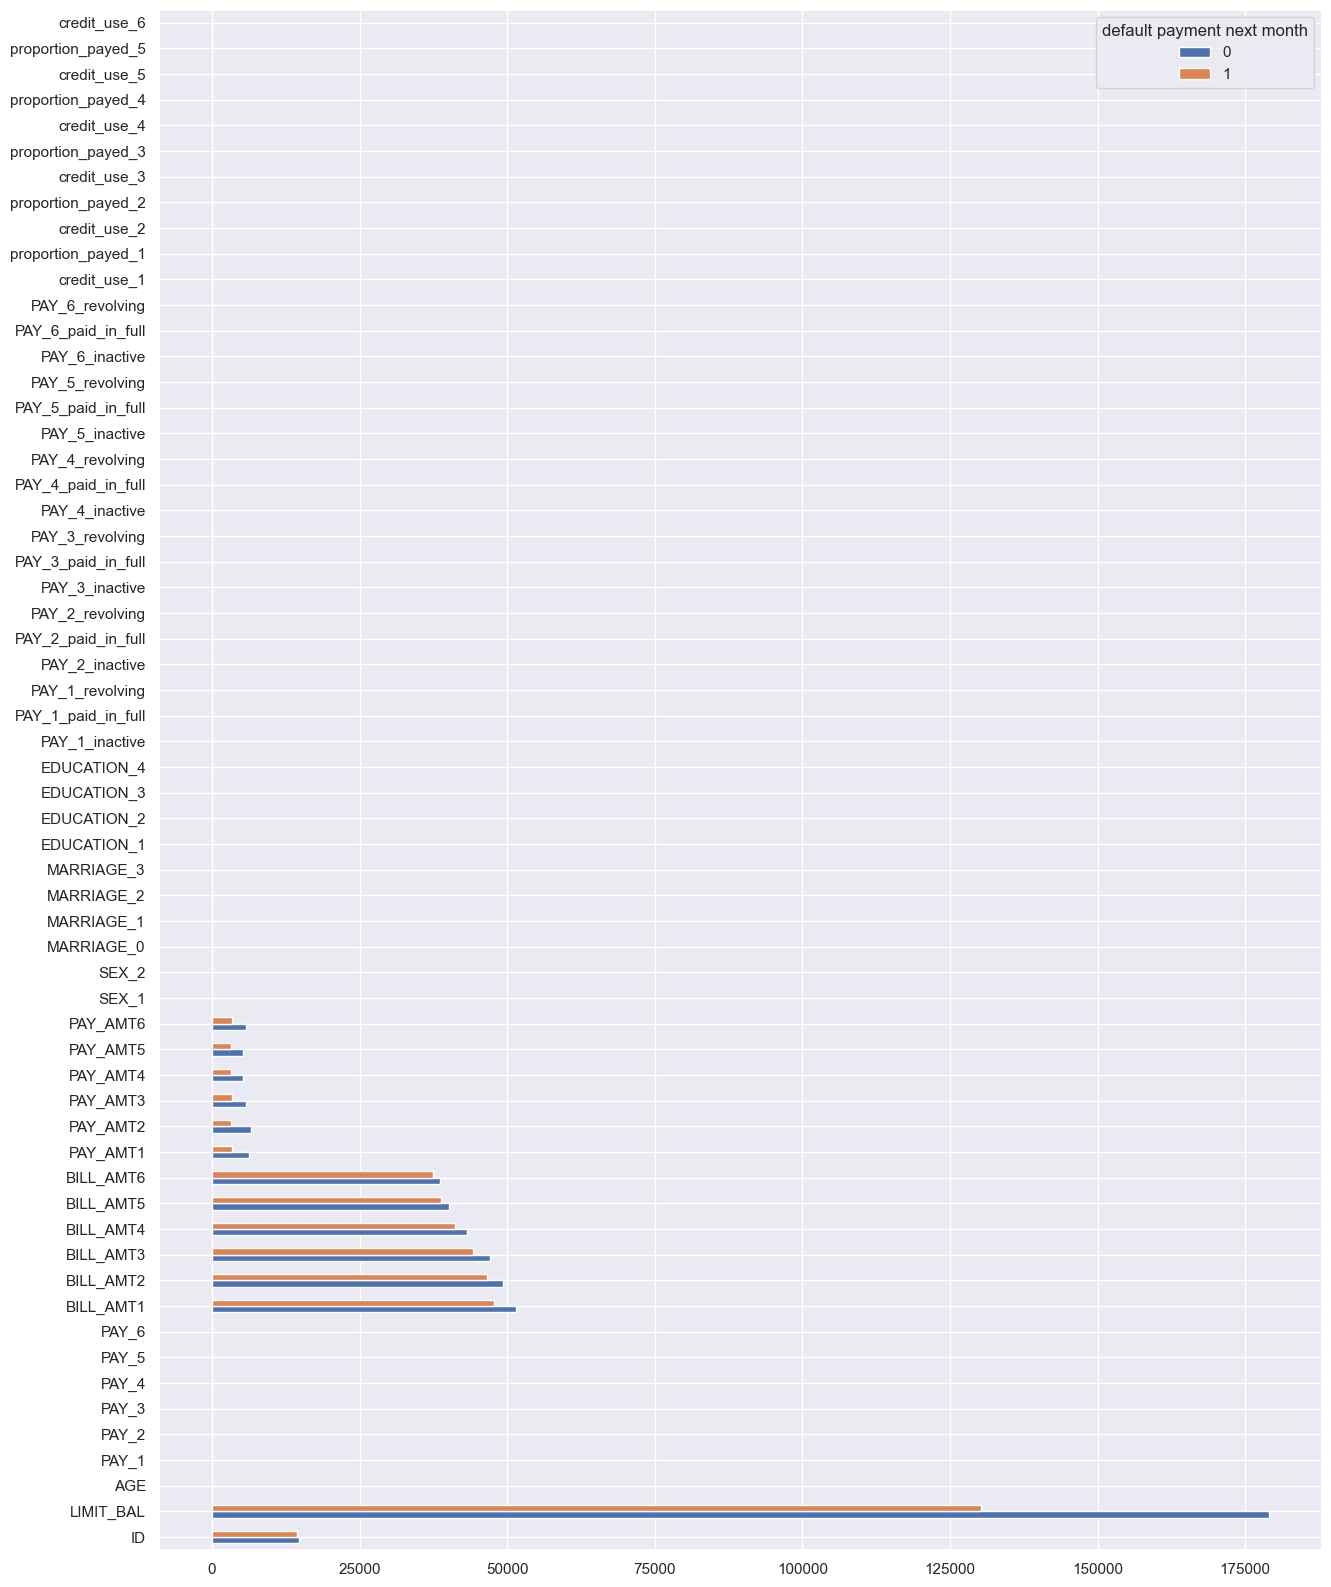

In [405]:
sns.set(rc={"figure.figsize":( 15,20)})
df =data.groupby(by = "default payment next month").mean()#/data.groupby(by = "default payment next month").max()
df.transpose().plot.barh()


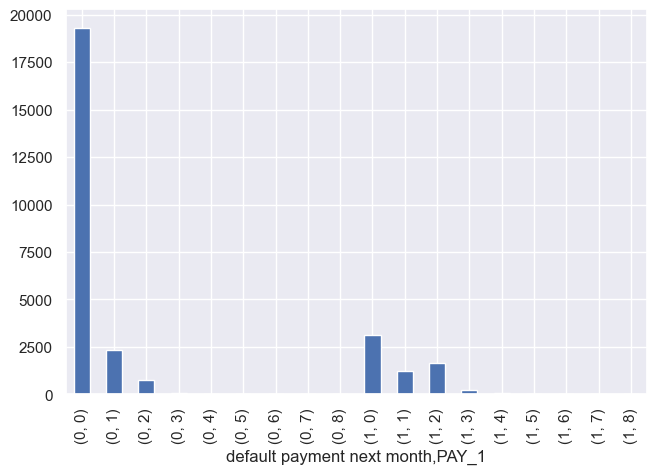

In [426]:
sns.set(rc={"figure.figsize":( 5*1.5,5)})
df = data[["default payment next month", "PAY_1"]].groupby(by = ["default payment next month","PAY_1"]).value_counts()#/data.groupby(by = "default payment next month").max()
fig = df.plot.bar()
plt.savefig("../images/bars.jpg")

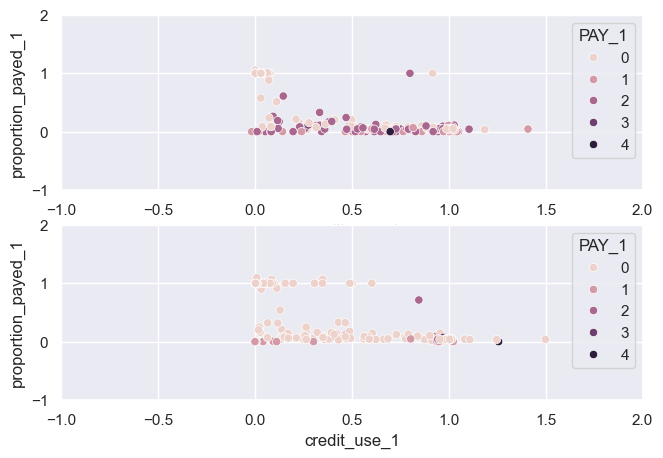

In [404]:

fig, ax = plt.subplots(2)
df = data[data["default payment next month"] == 1].sample(200)
sns.scatterplot(data=df, y="proportion_payed_1",  x="credit_use_1", hue = "PAY_1", ax=ax[0])
ax[0].set_xlim(-1,2)
ax[0].set_ylim(-1,2)
df = data[data["default payment next month"] == 0].sample(200)
sns.scatterplot(data=df, y="proportion_payed_1",  x="credit_use_1", hue = "PAY_1", ax=ax[1])
ax[1].set_xlim(-1,2)
ax[1].set_ylim(-1,2)

plt.savefig("../images/new_features.jpg")

In the nextplot, we see that even though the average "credit_use_1" values have different means/maxs, their distributions dont look to different. In the subsequent plot we consider the interaction between "credit_use_1" and "PAY_1". Note that "PAY_1" is takes value 0 frequently, in which case it collapses the values to 0. However, the interaction does significantly change the distributions so its probably something we want to consider for our model.

<Axes: xlabel='default payment next month', ylabel='credit_use_1'>

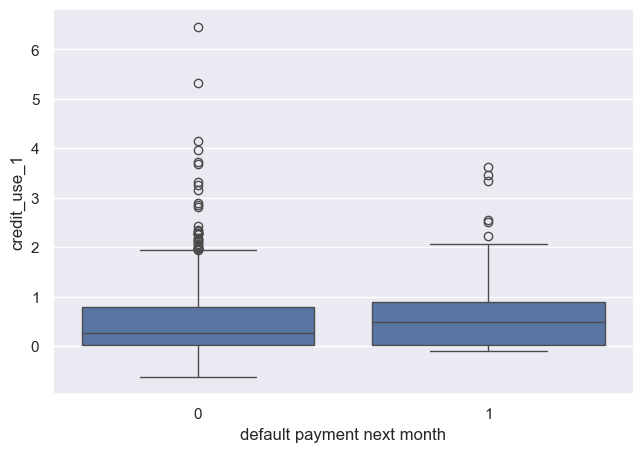

In [121]:
sns.set(rc={"figure.figsize":( 5*1.5,5)})
sns.boxplot(data=data,x = "default payment next month", y = data["credit_use_1"])

<Axes: xlabel='default payment next month', ylabel='None'>

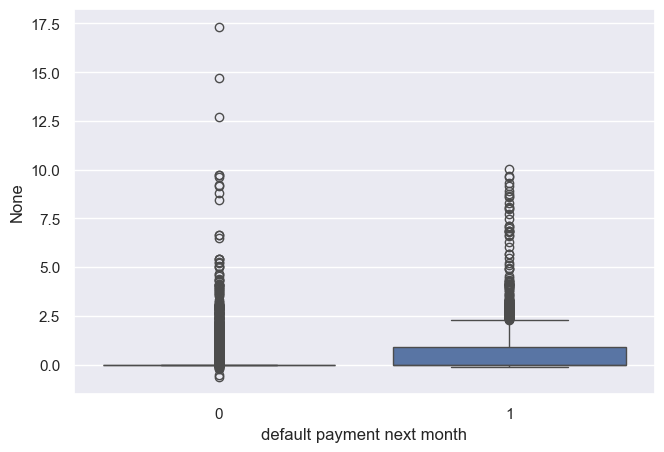

In [122]:
sns.boxplot(data=data,x = "default payment next month", y = data["PAY_1"]*data["credit_use_1"])

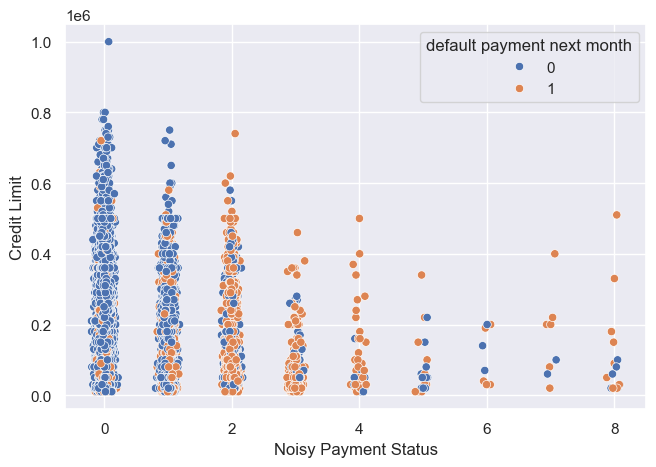

In [376]:
data["noise"]  =  np.random.normal(0, .05, size=(len(data),1))
sns.set(rc={"figure.figsize":( 5*1.5,5)})
fig = sns.scatterplot(data=data, x = data["PAY_1"] + data["noise"], y = "LIMIT_BAL", hue = "default payment next month")
fig.set(xlabel='Noisy Payment Status',
       ylabel='Credit Limit')
plt.savefig("../images/scatter.jpg")

## Splitting Data 

We need to make training and testing data. We will then split the training data to do 5-fold cross validation. While we do this we need to keep the following in mind to avoid data leaks and accurate model training:

- stratify data based on the target variable ("default payment next month")
- remove duplicates from the data to avoid data leaks (we did this at the top of the notebook)
- make sure that shifted pairs dont leak, which is probably easiest to do by removing shifted pairs (we did this at the top of the notebook)

In [300]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

X = data.drop(["default payment next month" , "ID", "noise"], axis = 1)
y = data["default payment next month"]

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42, stratify = y)

k = 5# common numbers of splits are 5,10,20
skf = StratifiedKFold(n_splits = k, shuffle=True, random_state=42) 

skf.split(X_train, y_train)

<generator object _BaseKFold.split at 0x1840dcb80>

## Training and Validating Models

We considered a few different models:

- KNN Classification with k in [5,10,15] (SONG)
- Logistic Regression without interaction (JUERGEN)
- Logistic Regression with interaction (JUERGEN)
- Support Vector Machines (SONG)
- Bayes (LDA, QDA, Naive) (JUERGEN)
- Decision Tree (Juergen)

Before training, we will scale the data.

We will consider the following metrics:
- accuracy 
- precision
- recall

In [305]:
# import model classes and metrics

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

score_functions = [accuracy_score, precision_score, recall_score]

In [309]:
# instanciate model objects
knn_5 = KNeighborsClassifier(5)
knn_10 = KNeighborsClassifier(10)
knn_15 =  KNeighborsClassifier(15)
log_reg = LogisticRegression(solver = "newton-cholesky",max_iter=100)
log_reg_poly = LogisticRegression(solver = "newton-cholesky",max_iter=100)
lda = LinearDiscriminantAnalysis()
qda = QuadraticDiscriminantAnalysis() # throws errors for illconditioned matrices 
gnb = GaussianNB()
svc = SVC()
tree = DecisionTreeClassifier(max_depth =4 , random_state=0)

# transformers
scaler = StandardScaler()
poly = PolynomialFeatures(2)

columns_to_drop = ["BILL_AMT{}".format(i) for i in range(1,7)]+["PAY_AMT{}".format(i) for i in range(1,7)]
dropper = FunctionTransformer(lambda df: df.drop(columns_to_drop, axis=1))

nothing = dropper = FunctionTransformer(lambda df: df)

poly_pipe = Pipeline([('dropper', dropper),('poly', poly),('scaler', scaler)])
knn_pipe = Pipeline([('dropper', dropper),('scaler', scaler)])

# make model list
model_list = [knn_5, knn_10, knn_15, log_reg, log_reg_poly, lda, qda, gnb, svc, tree]
model_dev = [tree]

pipeline_list = [knn_pipe, 
                 knn_pipe, 
                 knn_pipe,
                 scaler, 
                poly_pipe,
                scaler,
                scaler,
                scaler,
                scaler,
                nothing]
pipeline_dev = [nothing]

if False:
    pipeline_list = pipeline_dev
    model_list = model_dev

In [311]:
score_array = [] #list of lists, each list corresponds to a model and contains the scores 
for model_index, model in enumerate(model_list):
    model_scores = []
    for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
        X_tt = X_train.iloc[train_index]
        y_tt = y_train.iloc[train_index]

        X_val = X_train.iloc[test_index]
        y_val = y_train.iloc[test_index]

        #here is where piplines go (apply to tt and val data, but form normalization from tt)
        pipe = pipeline_list[model_index]
        pipe.fit(X_tt)
        X_ttt = pipe.transform(X_tt)
        X_vt = pipe.transform(X_val)
        
        #fit model 
        model.fit(X_ttt,y_tt)
  
        #get predictions
  
        pred = model.predict(X_vt)
        
        #make list of scores 
        scores = [ function(y_val, pred) for function in score_functions]
            
        #add scores to score array
        model_scores.append(scores)
        
    averages = [np.mean([model_scores[row][column] for row in range(k)]) for column in range(3)]
    score_array.append(averages)


/Users/juergenkritschgau/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/juergenkritschgau/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/juergenkritschgau/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/juergenkritschgau/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/juergenkritschgau/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.wa

In [312]:
score_array

[[0.7910364752618274, 0.5346762314225624, 0.34014760016989953],
 [0.8060336974331734, 0.6270450957852818, 0.27747239133512674],
 [0.8085042601982473, 0.6214729721714817, 0.31634613871977596],
 [0.8187337891508297, 0.6667762200631339, 0.3409388912486039],
 [0.804993328984611, 0.5865929605737377, 0.3649356191105448],
 [0.8202941257964242, 0.652034122731664, 0.38119897116428336],
 [0.5277170193311516, 0.28216013106188587, 0.6908222820016675],
 [0.33670070035095034, 0.24000276906868426, 0.9289824122579325],
 [0.8205541474648967, 0.6804361534831316, 0.3375670552330612],
 [0.8189503987346439, 0.6795513272678531, 0.3240822675287492]]

## Downsampling 
Our models are not very accurate. As an artifact of the imbalanced classes, guessing that each credit card client will not default would result in an accuracy of .78, while our models have accuracies around .82. We will now try to down sample our training data in hopes of trianing more accurate models.

In [369]:
# downsample 
from sklearn.utils import resample
small_class_size = len(y_train[y_train==1])
downsampled_0, downsampled_1 = resample(y_train[y_train==0], X_train[y_train == 0], n_samples = small_class_size, replace = False)
X_downsampled = pd.concat([X_train[y_train == 1], downsampled_1])
y_downsampled = pd.concat([y_train[y_train == 1], downsampled_0])

#retrain models
score_array = [] #list of lists, each list corresponds to a model and contains the scores 
for model_index, model in enumerate(model_list):
    model_scores = []
    for i, (train_index, test_index) in enumerate(skf.split(X_train , y_train)): # here is where the kfold split happens
        X_tt = X_train.iloc[train_index]
        y_tt = y_train.iloc[train_index]
        
        small_class_size = len(y_tt[y_tt==1])
        downsampled_0, downsampled_1 = resample(y_tt[y_tt==0], X_tt[y_tt == 0], n_samples = small_class_size, replace = False)
        X_tt = pd.concat([X_tt[y_tt == 1], downsampled_1])
        y_tt = pd.concat([y_tt[y_tt == 1], downsampled_0])

        X_val = X_train.iloc[test_index]
        y_val = y_train.iloc[test_index]

        #here is where piplines go (apply to tt and val data, but form normalization from tt)
        pipe = pipeline_list[model_index]
        pipe.fit(X_tt)
        X_ttt = pipe.transform(X_tt)
        X_vt = pipe.transform(X_val)
        
        #fit model 
        model.fit(X_ttt,y_tt)
  
        #get predictions
  
        pred = model.predict(X_vt)
        
        #make list of scores 
        scores = [ function(y_val, pred) for function in score_functions]
            
        #add scores to score array
        model_scores.append(scores)
        
    averages = [np.mean([model_scores[row][column] for row in range(k)]) for column in range(3)]
    score_array.append(averages)



/Users/juergenkritschgau/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/juergenkritschgau/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/juergenkritschgau/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/juergenkritschgau/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/juergenkritschgau/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.wa

In [370]:
score_array

[[0.6790341891299784, 0.3674371597716922, 0.6499463164849686],
 [0.7381559350434238, 0.425008219385969, 0.5612882863750059],
 [0.7214251881198163, 0.40694880908886466, 0.6005553195840609],
 [0.7632529289303223, 0.4675442127259757, 0.6001584941872355],
 [0.6995795358325808, 0.38596105247701207, 0.6334800289458367],
 [0.7676741144409049, 0.47413506477905276, 0.5763586058804095],
 [0.6249811751037049, 0.3588463025139247, 0.6412014095363947],
 [0.4669056679445148, 0.29269468422229517, 0.8194859360989193],
 [0.7715746836727074, 0.4819460449875977, 0.5803239102049805],
 [0.7779027792844897, 0.49310891170360643, 0.5315318876146428]]

## Conclusions and final test

We think that the SVC model is the best, and that the LDA is an exteremly close second. But all models seem pretty bad. 


In [425]:
#here is where piplines go (apply to tt and val data, but form normalization from tt)
pipe = scaler
pipe.fit(X_train)
X_train_transformed = pipe.transform(X_train)
X_test_transformed = pipe.transform(X_test)

#fit model 
svc.fit(X_train_transformed,y_train)

#get predictions
pred = svc.predict(X_test_transformed)

#make list of scores 
scores = [ function(y_test, pred) for function in score_functions]
    
#add scores to score array
print(scores)

[0.8261095700416089, 0.7080645161290322, 0.3481363996827914]
